In [1]:
import re

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout

import gensim
from gensim.models import word2vec
from gensim.models.phrases import Phraser, Phrases

import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import ngrams

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn import feature_extraction, model_selection, manifold
from sklearn.metrics import precision_recall_curve, accuracy_score, confusion_matrix, roc_auc_score, classification_report, roc_curve, auc, f1_score

import pandas as pd
import numpy as np
import html
import matplotlib.pyplot as plt
import seaborn as sns

c:\users\jurus\desktop\machine learing lab auta\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jurus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jurus\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
#DATA

df_train = pd.read_csv("C:/Users/jurus/Documents/AGH/Praca inżynierska/data_2/train.csv")
df_test = pd.read_csv("C:/Users/jurus/Documents/AGH/Praca inżynierska/data_2/test.csv")
df_labels = pd.read_csv("C:/Users/jurus/Documents/AGH/Praca inżynierska/data_2/submit.csv")

df_test['label'] = df_labels['label']

df = pd.concat([df_train, df_test]).reset_index(drop=True)

df.drop(columns=['author'], inplace=True)

# Combining 'title' and 'text' colmuns together
df['original'] = df['title'] + ' ' + df['text']

In [ ]:
# Shuffling data
df = df.sample(frac=1)
# Dropping duplicates & NaN rows
df.drop_duplicates(subset=['text'], inplace=True)
df.dropna(subset = ["text"], inplace=True)
df.dropna(subset = ["title"], inplace=True)

In [5]:
#DATA CLEANING

# Obtaining additional stopwords from nltk
stop_words = stopwords.words('english')

def cleaning(text):
    clean = re.sub('<.*?>', ' ', str(text))         
# Removing HTML tags
    clean = re.sub('\'.*?\s',' ', clean)               
# Removing all hanging letters afer apostrophes (s in it's)
    clean = re.sub(r'http\S+',' ', clean)              
# Removing URLs
    clean = re.sub('\W+',' ', clean)                   
# Replacing the non alphanumeric characters
    return html.unescape(clean)
df['cleaned'] = df['original'].apply(cleaning)


def stopwords(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        # Taking words that don't belong to stopwords and have more than 2 characters
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            result.append(token)

    return result
df['nostopwords'] = df['cleaned'].apply(stopwords)

In [7]:
# Lemmatizing
wnl = WordNetLemmatizer()
df['clean_lemm'] = df['nostopwords'].apply(lambda x: [wnl.lemmatize(word, pos="v") for word in x])
df['clean_lemm'] = df['clean_lemm'].apply(lambda x: [wnl.lemmatize(word, pos="a") for word in x])
df['clean_lemm'] = df['clean_lemm'].apply(lambda x: [wnl.lemmatize(word, pos="n") for word in x])

In [8]:
# All unique words present in dataset in one string
df['clean_joined'] = df['clean_lemm'].apply(lambda x: " ".join(x))
print(df['clean_joined'])

4829     berkeley ban coulter plan speak breitbart camp...
11762    teacher receive pushback compare build wall sh...
13104    russia army complete modernization program rbt...
25557    rice size hit bull time york time despite size...
18311    debate possibility worry campaign york time hi...
                               ...                        
8837     coulter immigrant privilege drive child rape e...
14996    roman polanski agree face rape charge judge re...
14775    giraffe tower otherworldly vulnerable extincti...
22053    israeli scientist develop blood test diagnose ...
18450    share mission pardon soldier kill civilian yor...
Name: clean_joined, Length: 25433, dtype: object


In [66]:
#WORD2VEC

# Target class is 'label'
x_train, x_test, y_train, y_test = train_test_split(df.clean_joined, df.label, test_size=0.2)

# Creating list of lists of unigrams - training and testing corpus

def corpus(corpus):
    lst_corpus = []
    for string in corpus:
        lst_words = string.split()
        lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, len(lst_words), 1)]
        lst_corpus.append(lst_grams)
    return lst_corpus

corpus_train = corpus(x_train)
corpus_test = corpus(x_test)

# Creating relevant phrases from the corpus:
phrases_train = Phrases(corpus_train)
phrases_test = Phrases(corpus_test)


# The Phraser object is used to transform sentences
bigram_train = Phraser(phrases_train)
bigram_test = Phraser(phrases_test)


# Applying the Phraser to transform corpus
all_phrases_train = list(bigram_train[corpus_train])
all_phrases_test= list(bigram_test[corpus_test])


# Fitting Word2Vec
nlp_train = word2vec.Word2Vec(all_phrases_train, vector_size=300, window=5, min_count=7, sg=1)
nlp_test = word2vec.Word2Vec(all_phrases_test, vector_size=300, window=5, min_count=7, sg=1)

In [67]:
nlp_train.wv.most_similar('language')

[('dialect', 0.5748217701911926),
 ('fluent', 0.5529404282569885),
 ('hindi', 0.552388608455658),
 ('native_language', 0.550155520439148),
 ('mother_tongue', 0.546684741973877),
 ('different_language', 0.545417845249176),
 ('vocabulary', 0.5426989793777466),
 ('fluency', 0.535427987575531),
 ('english_spanish', 0.5174385905265808),
 ('verb', 0.5167146325111389)]

In [12]:
# Checking corpuses for fake and real news

df_true = df.loc[(df['label'] == 0)]
df_fake = df.loc[(df['label'] == 1)]

x_fake = df_fake.clean_joined
x_true = df_true.clean_joined

corpus_fake = corpus(x_fake)
corpus_true = corpus(x_true)

#Create the relevant phrases from the list of sentences:
phrases_fake = Phrases(corpus_fake)
phrases_true = Phrases(corpus_true)


# The Phraser object is used from now on to transform sentences
bigram_fake = Phraser(phrases_fake)
bigram_true = Phraser(phrases_true)


# Applying the Phraser to transform our sentences is simply
all_phrases_fake = list(bigram_train[corpus_fake])
all_phrases_true= list(bigram_test[corpus_true])


# Fitting Word2Vec
embed_dim = 300 

nlp_fake = word2vec.Word2Vec(all_phrases_fake, vector_size=embed_dim, window=5, min_count=5, sg=1)
nlp_true = word2vec.Word2Vec(all_phrases_true, vector_size=embed_dim, window=5, min_count=5, sg=1)


# Listing similar words to 'trump' in fake and real datasets
print(nlp_fake.wv.most_similar('trump'))
print(nlp_true.wv.most_similar('trump'))

[('donald_trump', 0.6300867795944214), ('republican_candidate', 0.6272005438804626), ('republican_convention', 0.6048397421836853), ('republican_nominee', 0.5957688689231873), ('hrafnkell_haraldsson', 0.5933564305305481), ('machado', 0.5903124809265137), ('donald', 0.5892179608345032), ('immigration_stance', 0.5858463644981384), ('donald_trumpâ', 0.5855476260185242), ('divisive_vision', 0.5855449438095093)]
[('donald_trump', 0.6887159943580627), ('trump_presumptive', 0.6762503981590271), ('indiana_governor', 0.6392880082130432), ('incoming_president', 0.6339762806892395), ('senor', 0.6328524947166443), ('fiorina', 0.6305186152458191), ('trump_candidacy', 0.62835294008255), ('disincline', 0.6236808896064758), ('distract_attention', 0.6146733164787292), ('trump_unfit', 0.6141461730003357)]


In [69]:
#PADDING

# Creating sequneces of tokenized words
tokenizer = Tokenizer(lower=True, split=' ')
tokenizer.fit_on_texts(all_phrases_train )
dic_vocabulary = tokenizer.word_index

lst_text2seq_train = tokenizer.texts_to_sequences(all_phrases_train)
lst_text2seq_test = tokenizer.texts_to_sequences(all_phrases_test)


# Adding padding
padded_train = pad_sequences(lst_text2seq_train, maxlen=100, padding='post', truncating='post')
padded_test = pad_sequences(lst_text2seq_test, maxlen=100, truncating='post')

In [70]:
#PREPARING THE DATA FOR KERAS EMBEDDING LAYER

# Creating a dictionary with words in vocab and their embeddings
vocab = nlp_train.wv.key_to_index
print("The no of words :", len(vocab))
vocab = list(nlp_train.wv.key_to_index.keys())
             
word_vec_dict = {}
for word in vocab:
    word_vec_dict[word]=nlp_train.wv.get_vector(word)
print("The no of key-value pairs : ",len(word_vec_dict)) # should come equal to vocab size

vocab_size = len(tokenizer.word_index) + 1  # total no of words

# Creating the embedding matrix

embed_dim = 300
embeddings = np.zeros(shape=(vocab_size, embed_dim))

for word,i in dic_vocabulary.items():
    embed_vector = word_vec_dict.get(word)
    if embed_vector is not None:  # word is in the vocabulary learned by the w2v model
        embeddings[i]=embed_vector
    # if word is not found then embed_vector corressponding to that vector will stay zero.


The no of words : 56806
The no of key-value pairs :  56806


In [73]:
#BUILDING AND TRAINING MODEL

model = Sequential()
# takes the sequences as input and the word vectors as weights
model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, mask_zero=False, weights=[embeddings], trainable=False))
# helps to prevent overfitting by ignoring randomly selected neurons 
model.add(Bidirectional(LSTM(100, return_sequences=False))) # 100 memory units (smart neurons)
model.add(Dropout(0.2))
# fully connected dense layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))  
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

y_train = np.asarray(y_train)

#Training the mode
training = model.fit(padded_train, y_train, batch_size=64, validation_split=0.1, epochs=2)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 300)         53258700  
_________________________________________________________________
bidirectional_6 (Bidirection (None, 200)               320800    
_________________________________________________________________
dropout_12 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                12864     
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 53,592,429
Trainable params: 333,729
Non-trainable params: 53,258,700
____________________________________

Model accuracy is :  0.8777275407902496
              precision    recall  f1-score   support

           0       0.88      0.87      0.88      2551
           1       0.87      0.88      0.88      2536

    accuracy                           0.88      5087
   macro avg       0.88      0.88      0.88      5087
weighted avg       0.88      0.88      0.88      5087



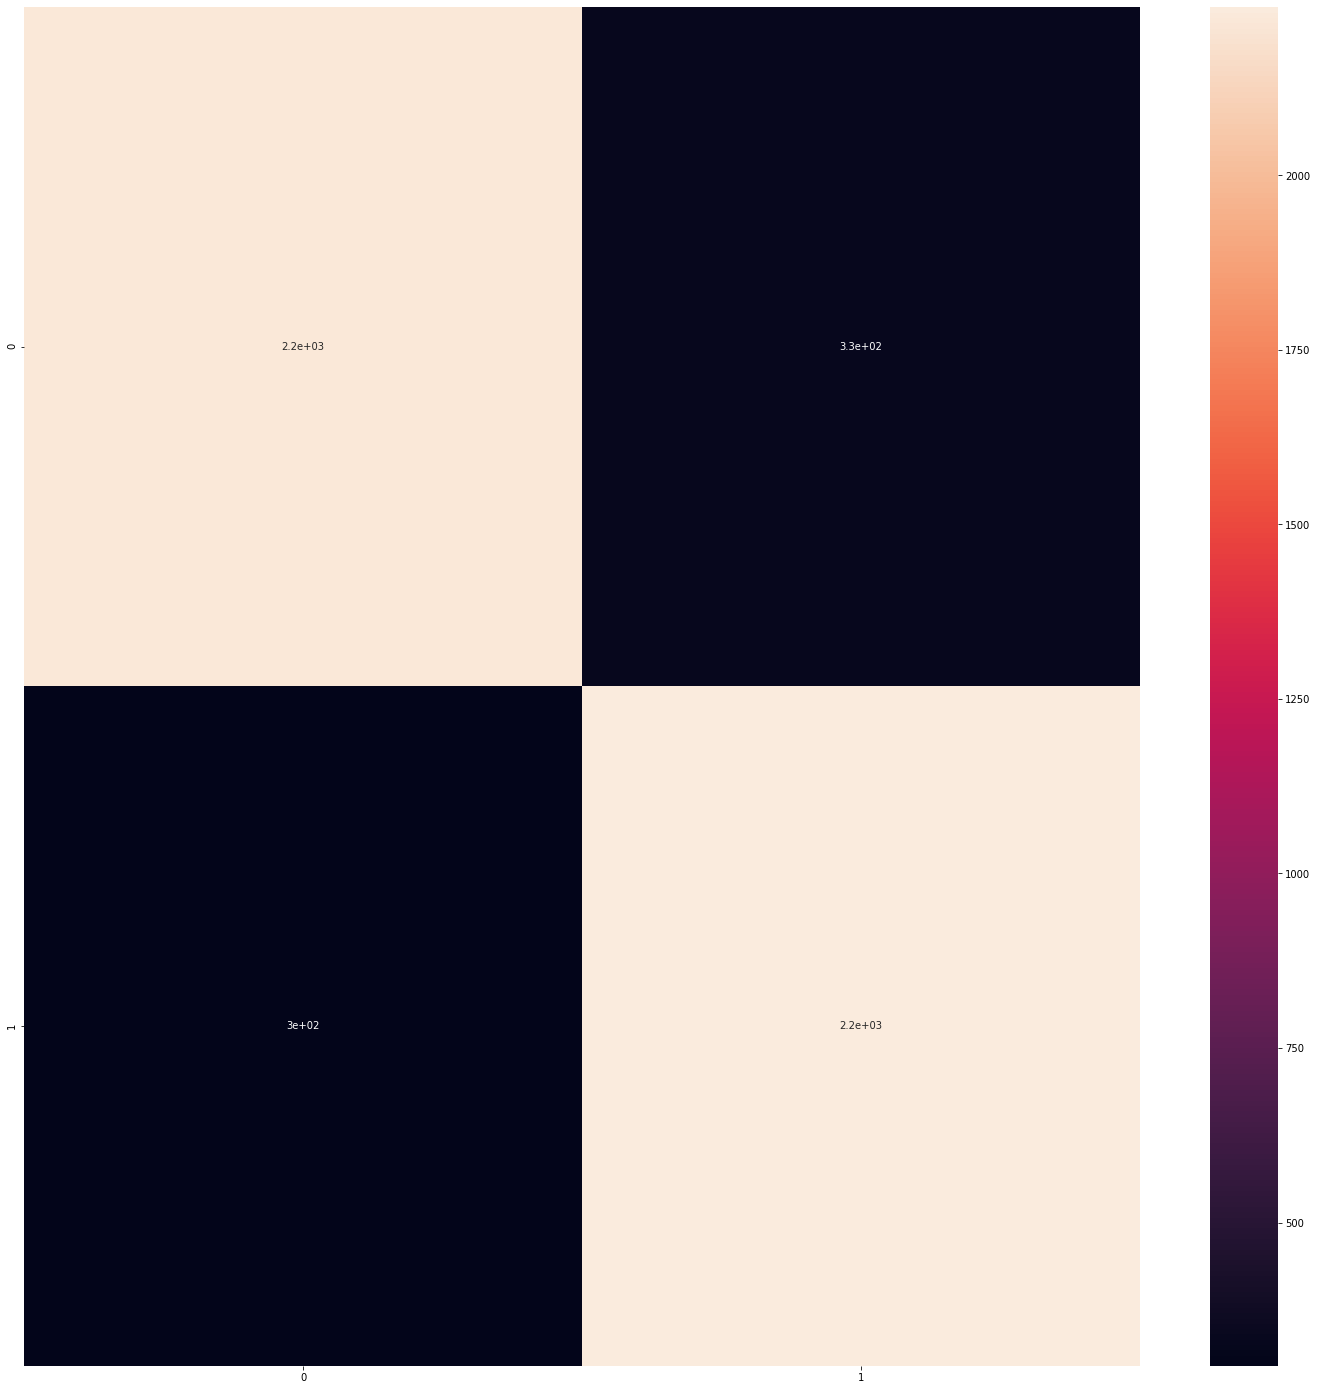

In [74]:
#ASSESING TRAINED MODEL PERFORMANCE

pred = model.predict(padded_test)

prediction = []
# If hte prediction is > 0.5 then the news is real otherwise it is fake
for i in range(len(pred)):
    if pred[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)

# Getting accuracy
accuracy = accuracy_score(list(y_test), prediction)
print("Model accuracy is : ", accuracy)
print(classification_report(y_test, prediction))

# Confusion matrix
c_matrix = confusion_matrix(list(y_test), prediction)
plt.figure(figsize=(25,25))
sns.heatmap(c_matrix, annot=True)
plt.show()

No Skill: ROC AUC=0.500
Naive Bayes: ROC AUC=0.939


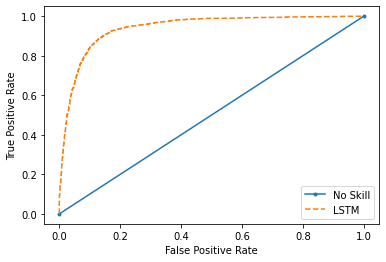

In [87]:
#ROC-CURVE

# Generetong a no skill prediction
ns_probs = [0 for _ in range(len(y_test))]

# Calculating scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

# Summarizing scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Naive Bayes: ROC AUC=%.3f' % (lr_auc))

# Calculating ROC curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

# Plotting ROC curves
pyplot.plot(ns_fpr, ns_tpr, marker='.', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, linestyle='--', label='LSTM')

#Axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

# Showing the legend
pyplot.legend()

#Showing the plot
pyplot.show()